In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ezplot.ezplot import plot
from data import Data
from scipy import stats

plt.style.use('seaborn')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [71]:
file_name = 'data/20220325/test_2_uav.txt'
df = pd.read_csv(file_name, header=0, skipinitialspace=True)

cols = ['ypr_0', 'ypr_1', 'ypr_2', 'a_0', 'a_1', 'a_2', 'W_0', 'W_1', 'W_2']

# Outlier rejection
Q1 = df[cols].quantile(0.05)
Q3 = df[cols].quantile(0.95)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


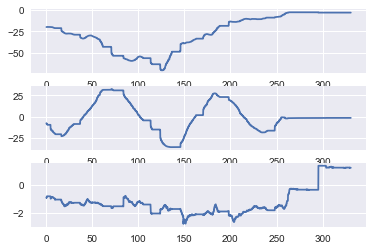

In [72]:
data = Data(df)
plot(data.t, data.rtk_x)

-13.079998970031738


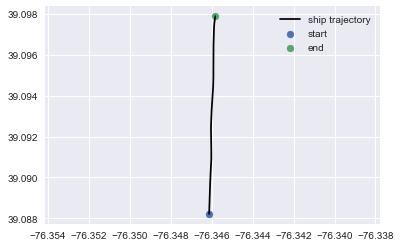

In [73]:
R_0 = data.R[:, :, 0]
R_base_0 = data.base_R[:, :, 0]

plt.figure()
plt.plot(data.base_llh[1, :], data.base_llh[0, :], 'k', label='ship trajectory')
plt.scatter(data.base_llh[1, 0], data.base_llh[0, 0], label='start')
plt.scatter(data.base_llh[1, -1], data.base_llh[0, -1], label='end')
plt.axis('equal')
plt.legend()

# Find base yaw angle
base_imu_yaw_0 = np.arctan2(R_base_0[1, 0], R_base_0[0, 0])
print(base_imu_yaw_0 / np.pi * 180.0)

In [74]:

def generate_ship_coordinates():
    '''
    Generates coordinates for the ship for plotting with respect to ship's
    coordinates frame

    Args:
        None

    Returns:
        ship: 3x6 np array
    '''
    W = 7.3     # width
    L = 32.9    # length
    D = 8       # deck length
    B = 5       # bow length
    ship = np.zeros((3, 6))
    ship[0, :] = np.array([W/2, -W/2, -W/2, 0, W/2, W/2])
    ship[1, :] = np.array([-D, -D, L-D-B, L-D, L-D-B, -D])
    ship[2, :] = np.array([0, 0, 0, 0, 0, 0])

    return ship

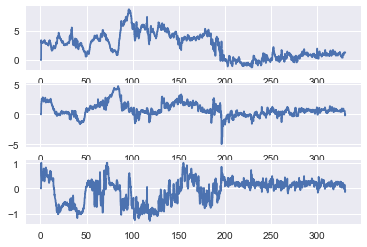

In [75]:
plot(data.t, data.ane2)

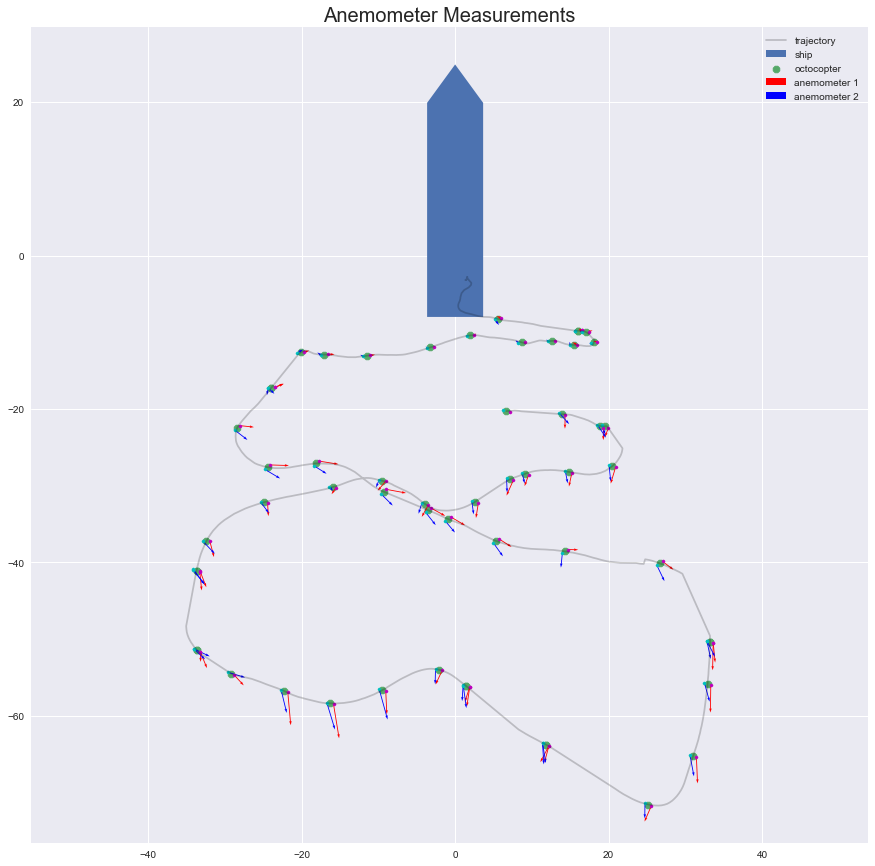

In [76]:
def plot_anemometer(ship, uav_traj, uav_pos, ane1_pos, ane2_pos, ane1_uvw, ane2_uvw, scale=1):
    
    fig = plt.figure(figsize=(15, 15))

    plt.fill(ship[0, :], ship[1, :], label='ship')
    plt.plot(uav_traj[0, :], uav_traj[1, :], 'k', label='trajectory', alpha=0.2)
    plt.scatter(uav_pos[0, :], uav_pos[1, :], label='octocopter', linewidth=1.0,
        marker='8')

    plt.quiver(ane1_pos[0, :], ane1_pos[1, :], ane1_uvw[1, :], -ane1_uvw[0, :],
            color='r', scale=scale, scale_units='x', width=0.001,
            label='anemometer 1')
    plt.quiver(ane2_pos[0, :], ane2_pos[1, :], ane2_uvw[1, :], -ane2_uvw[0, :],
            color='b', scale=scale, scale_units='x', width=0.001,
            label='anemometer 2')
    plt.scatter(ane1_pos[0, :], ane1_pos[1, :], c='m', s=10.0)
    plt.scatter(ane2_pos[0, :], ane2_pos[1, :], c='c', s=10.0)

    plt.axis('equal')
    # plt.grid()
    plt.legend()

    plt.title('Anemometer Measurements', fontsize=20)
        
    return


# Data in ship frame
N = data.N
uav_traj = np.zeros((3, N))
uav_pos = np.zeros((3, N))
ane1_pos = np.zeros((3, N))
ane2_pos = np.zeros((3, N))
ane1_uvw = np.zeros((3, N))
ane2_uvw = np.zeros((3, N))

plot_interval = 200 # data will be plotted at this interval
j = 0

# Rotation from NED frame to Ship
base_imu_to_ship_rotation = 100.0 / 180.0 * np.pi
theta = base_imu_yaw_0 + base_imu_to_ship_rotation
R_ship_ned = np.array([
    [np.cos(theta), -np.sin(theta), 0.0],
    [np.sin(theta), np.cos(theta), 0.0],
    [0.0, 0.0, 1.0]
])


# Physical orientation of each anemomater with respect to the IMU
x_i1 = np.array([-0.45, 0.0, 0.0])
R_i1 = np.array([[-1, 0, 0],
    [0, -1, 0],
    [0, 0, -1]
])

x_i2 = np.array([0.45, 0.0, 0.0])
R_i2 = np.array([[1, 0, 0],
    [0, 1, 0],
    [0, 0, -1]
])

a_magnitude = np.zeros(N)

for i in range(N):
    if i > 8000:
        theta = 40.0 / 180.0 * np.pi
    else:
        theta = 70.0 / 180.0 * np.pi
    R_ane = np.array([
        [np.cos(theta), -np.sin(theta), 0.0],
        [np.sin(theta), np.cos(theta), 0.0],
        [0.0, 0.0, 1.0]
    ])

    uav_traj[:, i] = R_ship_ned @ data.rtk_x[:, i]

    if i % plot_interval != 0:
        continue

    # Find anemometer position in ship frame
    uav_pos[:, j] = R_ship_ned @ data.rtk_x[:, i]
    ane1_pos[:, j] = R_ship_ned @ (data.rtk_x[:, i] 
        + R_ane @ data.R[:, :, i] @ x_i1)
    ane2_pos[:, j] = R_ship_ned @ (data.rtk_x[:, i] 
        + R_ane @ data.R[:, :, i] @ x_i2)
    a_magnitude[j] = np.linalg.norm(data.a[:, i])

    ane1_uvw[:, j] = data.R[:, :, i] @ R_i1 @ data.ane1[:, i]
    ane2_uvw[:, j] = data.R[:, :, i] @ R_i2 @ data.ane2[:, i]

    j += 1

uav_pos = uav_pos[:, :j]
ane1_pos = ane1_pos[:, :j]
ane2_pos = ane2_pos[:, :j]

ane1_uvw = ane1_uvw[:, :j]
ane2_uvw = ane2_uvw[:, :j]

a_magnitude = a_magnitude[:j]
a_magnitude_norm = a_magnitude / np.max(a_magnitude)


ship = generate_ship_coordinates()
plot_anemometer(ship, uav_traj, uav_pos, ane1_pos, ane2_pos, ane1_uvw, ane2_uvw, 2)
plt.savefig('anemometer_measurements.png', transparent=False, dpi=300)

In [77]:
N

14477

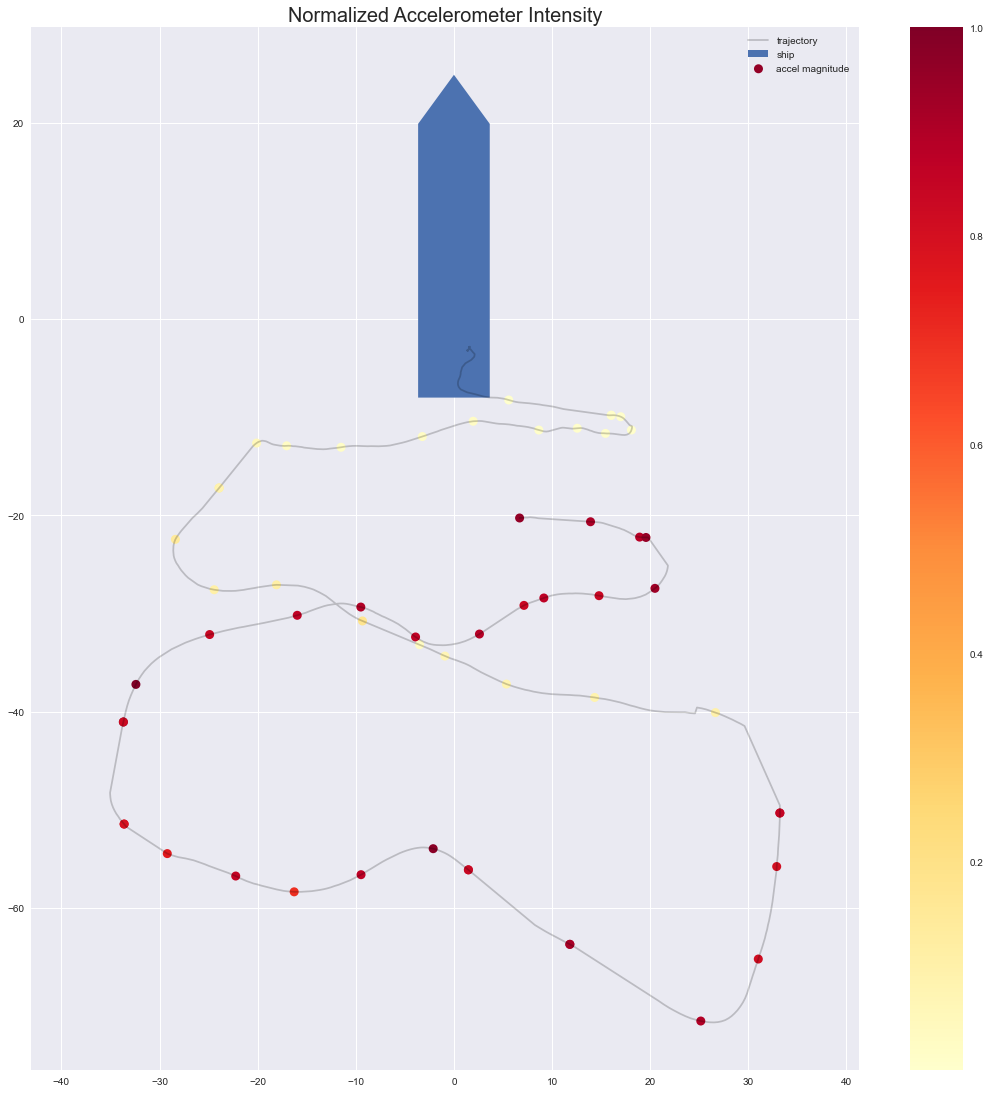

In [78]:
def plot_acceleromoter(ship, uav_traj, uav_pos, a_magnitude, scale=1):
    
    fig = plt.figure(figsize=(15, 15))

    plt.fill(ship[0, :], ship[1, :], label='ship')
    plt.plot(uav_traj[0, :], uav_traj[1, :], 'k', label='trajectory', alpha=0.2)
    plt.scatter(uav_pos[0, :], uav_pos[1, :], label='accel magnitude', linewidth=2.0,
        c=a_magnitude, cmap='YlOrRd')

    plt.axis('equal')
    # plt.grid()
    plt.legend()
    plt.tight_layout()

    cbar = plt.colorbar();
    plt.title('Normalized Accelerometer Intensity', fontsize=20)
        
    return


plot_acceleromoter(ship, uav_traj, uav_pos, a_magnitude_norm)
plt.savefig('accelerometer_magnitude.png', transparent=False, dpi=300)